# Homework 1. Which of two things is larger?

Due: Thursday, September 19, 11:59 PM

<a href=https://raw.github.com/cs109/content/master/HW1.ipynb download=HW1.ipynb> Download this assignment</a>

---

Useful libraries for this assignment

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting
* [requests](http://docs.python-requests.org/en/latest/), for downloading web content
* [pattern](http://www.clips.ua.ac.be/pages/pattern), for parsing html and xml pages
* [fnmatch](http://docs.python.org/2/library/fnmatch.html) (optional), for Unix-style string matching

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from fnmatch import fnmatch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
#from pattern import web
from bs4 import BeautifulSoup


# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

C:\Users\jzhou1\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Introduction

This was the [XKCD comic](http://xkcd.com/1131/) after the 2012 Presidential election:

<img src="http://imgs.xkcd.com/comics/math.png">

The comic refers to the fact that Nate Silver's statistical model (which is based mostly on combining information from pre-election polls) correctly predicted the outcome of the 2012 presidential race in all 50 states. 

Polling data isn't a perfect predictor for the future, and some polls are more accurate than others. This means that election forecastors must consider prediction uncertainty when building models.

In this first assignment, you will perform a simple analysis of polling data about the upcoming <a href="http://en.wikipedia.org/wiki/Governor_(United_States)">Governor races</a>. The assignment has three main parts:

**First** you will build some tools to download historical polling data from the web, and parse it into a more convenient format. 

**Next** you will use these tools to aggregate and visualize several past Governor races

**Finally** you will run a bootstrap analysis to estimate the probable outcome of current Governor races, given the level of precision of historical polls.

---


## Part 1: Collect and Clean

The [Real Clear Politics](http://www.realclearpolitics.com) website archives many political polls. In addition, they combine related polls to form an "RCP average" estimate of public opinion over time. For example, the chart on [this page](http://www.realclearpolitics.com/epolls/2012/president/us/general_election_romney_vs_obama-1171.html) shows historical polling data for the Obama-Romney presidential race. The chart is an average of the polling data table below the chart.

The data used to generate plots like this are stored as XML pages, with URLs like:

http://charts.realclearpolitics.com/charts/[id].xml

Here, [id] is a unique integer, found at the end of the URL of the page that displays the graph. The id for the Obama-Romney race is 1171:

http://charts.realclearpolitics.com/charts/1171.xml

Opening this page in Google Chrome or Firefox will show you the XML content in an easy-to-read format. Notice that XML tags are nested inside each other, hierarchically (the jargony term for this is the "Document Object Model", or "DOM"). The first step of webscraping is almost always exploring the HTML/XML source in a browser, and getting a sense of this hierarchy.

---

#### Problem 0

The above XML page includes 5 distinct tags (one, for example, is `chart`). List these tags, and depict how they nest inside each other using an indented list. For example:

* Page
  * Section
     * Paragraph
  * Conclusion

* Chart
    * Series
        * Value
    * Graphs
        * Graph
            * Value
        * Graph
            * Value

---
#### Problem 1

We want to download and work with poll data like this. Like most programming tasks, we will break this into many smaller, easier pieces

Fill in the code for the `get_poll_xml` function, that finds and downloads an XML page discussed above

**Hint** 

`requests.get("http://www.google.com").text` downloads the text from Google's homepage

In [2]:
"""
Function
--------
get_poll_xml

Given a poll_id, return the XML data as a text string

Inputs
------
poll_id : int
    The ID of the poll to fetch

Returns
-------
xml : str
    The text of the XML page for that poll_id

Example
-------
>>> get_poll_xml(1044)
u'<?xml version="1.0" encoding="UTF-8"?><chart><series><value xid=\'0\'>1/27/2009</value>
...etc...
"""    
def get_poll_xml(poll_id):
    xml = requests.get(r"http://charts.realclearpolitics.com/charts/" + str(poll_id) + r'.xml').text
    return xml

Here are some other functions we'll use later. `plot_colors` contains hints about parsing XML data.

In [4]:
# "r"egular "e"xpressions is kind of a mini-language to
# do pattern matching on text
import re

def _strip(s):
    """This function removes non-letter characters from a word
    
    for example _strip('Hi there!') == 'Hi there'
    """
    return re.sub(r'[\W_]+', '', s)

def plot_colors(xml):
    """
    Given an XML document like the link above, returns a python dictionary
    that maps a graph title to a graph color.
    
    Both the title and color are parsed from attributes of the <graph> tag:
    <graph title="the title", color="#ff0000"> -> {'the title': '#ff0000'}
    
    These colors are in "hex string" format. This page explains them:
    http://coding.smashingmagazine.com/2012/10/04/the-code-side-of-color/
    
    Example
    -------
    >>> plot_colors(get_poll_xml(1044))
    {u'Approve': u'#000000', u'Disapprove': u'#FF0000'}
    """
    soup = BeautifulSoup(xml, 'html.parser')
    result = {}
    for graph in soup.find_all('graph'):
        title = _strip(graph['title'])
        result[title] = graph['color']
    return result

plot_colors(get_poll_xml(1044))

{u'Approve': u'#000000', u'Disapprove': u'#FF0000'}

---

#### Problem 2

Even though `get_poll_xml` pulls data from the web into Python, it does so as a block of text. This still isn't very useful. Use the `web` module in `pattern` to parse this text, and extract data into a pandas DataFrame.

**Hints**

* You might want create python lists for each column in the XML. Then, to turn these lists into a DataFrame, run

`pd.DataFrame({'column_label_1': list_1, 'column_label_2':list_2, ...})`

* use the pandas function `pd.to_datetime` to convert strings into dates

In [96]:
"""
    Function
    ---------
    rcp_poll_data

    Extract poll information from an XML string, and convert to a DataFrame

    Parameters
    ----------
    xml : str
        A string, containing the XML data from a page like 
        get_poll_xml(1044)
        
    Returns
    -------
    A pandas DataFrame with the following columns:
        date: The date for each entry
        title_n: The data value for the gid=n graph (take the column name from the `title` tag)
        
    This DataFrame should be sorted by date
        
    Example
    -------
    Consider the following simple xml page:
    
    <chart>
    <series>
    <value xid="0">1/27/2009</value>
    <value xid="1">1/28/2009</value>
    </series>
    <graphs>
    <graph gid="1" color="#000000" balloon_color="#000000" title="Approve">
    <value xid="0">63.3</value>
    <value xid="1">63.3</value>
    </graph>
    <graph gid="2" color="#FF0000" balloon_color="#FF0000" title="Disapprove">
    <value xid="0">20.0</value>
    <value xid="1">20.0</value>
    </graph>
    </graphs>
    </chart>
    
    Given this string, rcp_poll_data should return
    result = pd.DataFrame({'date': pd.to_datetime(['1/27/2009', '1/28/2009']), 
                           'Approve': [63.3, 63.3], 'Disapprove': [20.0, 20.0]})
"""
def rcp_poll_data(xml):
    soup = BeautifulSoup(xml, 'html.parser')
    #dates
    date_soup = soup.find('series').find_all('value')
    date_l = [date_str.text for date_str in date_soup]
    #titles
    no_titles = len(soup.find_all('graph'))
    values = []
    titles = []
    for n in range(no_titles):
        title_n = soup.find_all('graph')[n]['title']
        titles.append(title_n)
        value_soup = soup.find_all('graph')[n].find_all('value')
        values_l = [float(value_str.text) if value_str.text is not u'' else 0 for value_str in value_soup ]
        values.append(values_l)
    title_val_dict = dict(zip(titles, values))
    title_val_dict.update({'date':pd.to_datetime(date_l)})
    result = pd.DataFrame(title_val_dict)
    return result
    
xml = get_poll_xml(1171)
df = rcp_poll_data(xml)
print df

     Obama  Romney       date
0     47.5    41.5 2011-02-01
1     47.5    41.5 2011-02-02
2     47.5    41.5 2011-02-03
3     47.5    41.5 2011-02-04
4     47.5    41.5 2011-02-05
5     47.5    41.5 2011-02-06
6     46.4    42.0 2011-02-07
7     46.4    42.0 2011-02-08
8     46.7    42.7 2011-02-09
9     46.7    42.7 2011-02-10
10    47.3    42.0 2011-02-11
11    47.3    42.0 2011-02-12
12    47.3    42.0 2011-02-13
13    47.3    42.0 2011-02-14
14    47.3    42.0 2011-02-15
15    47.0    41.7 2011-02-16
16    47.0    41.7 2011-02-17
17    47.0    41.7 2011-02-18
18    47.0    41.7 2011-02-19
19    47.0    41.7 2011-02-20
20    47.0    41.7 2011-02-21
21    47.0    41.7 2011-02-22
22    47.3    42.8 2011-02-23
23    47.3    42.8 2011-02-24
24    47.3    42.8 2011-02-25
25    47.3    42.8 2011-02-26
26    47.3    42.8 2011-02-27
27    47.3    42.8 2011-02-28
28    47.3    42.8 2011-03-01
29    47.6    42.4 2011-03-02
..     ...     ...        ...
622   47.3    47.4 2012-10-15
623   47.0

The output from `rcp_poll_data` is much more useful for analysis. For example, we can plot with it:

In [103]:
def poll_plot(poll_id):
    """
    Make a plot of an RCP Poll over time
    
    Parameters
    ----------
    poll_id : int
        An RCP poll identifier
    """

    # hey, you wrote two of these functions. Thanks for that!
    xml = get_poll_xml(poll_id)
    data = rcp_poll_data(xml)
    colors = plot_colors(xml)

    #remove characters like apostrophes
    data = data.rename(columns = {c: _strip(c) for c in data.columns})
    
    #normalize poll numbers so they add to 100%   
    norm = data[colors.keys()].sum(axis=1) / 100    
    for c in colors.keys():
        data[c] /= norm
    
    for label, color in colors.items():
        plt.plot(data.date, data[label], color=color, label=label)        
        
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage")

If you've done everything right so far, the following code should reproduce the graph on [this page](http://www.realclearpolitics.com/epolls/other/president_obama_job_approval-1044.html)

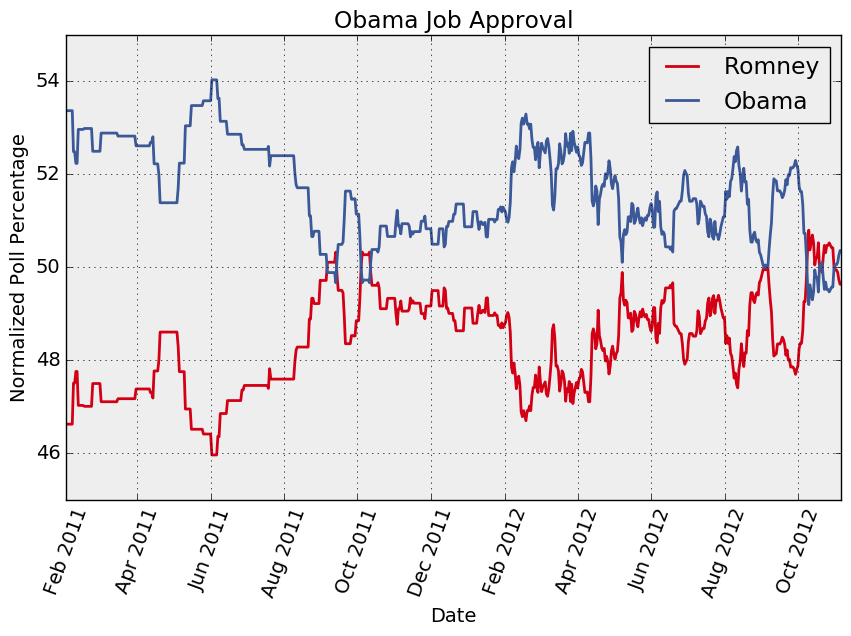

In [104]:
poll_plot(1171)
plt.title("Obama Job Approval")

---

## Part 2: Aggregate and Visualize


#### Problem 3

Unfortunately, these data don't have any error bars. If a candidate leads by 10% in the RCP average, is she a shoo-in to win? Or is this number too close to call? Does a 10% poll lead mean more 1 day before a race than it does 1 week before? Without error estimates, these questions are impossible to answer.

To get a sense of how accurate the RCP polls are, you will gather data from many previous Governor races, where the outcome is known.

This url has links to many governer races. 

http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html

Notice that each link to a governor race has the following URL pattern:

http://www.realclearpolitics.com/epolls/[YEAR]/governor/[STATE]/[TITLE]-[ID].html


Write a function that scans html for links to URLs like this

**Hint** The [fnmatch](http://docs.python.org/2/library/fnmatch.html) function is useful for simple string matching tasks.

In [99]:
"""
    Function
    --------
    find_governor_races

    Find and return links to RCP races on a page like
    http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html
    
    Parameters
    ----------
    html : str
        The HTML content of a page to scan
        
    Returns
    -------
    A list of urls for Governer race pages
    
    Example
    -------
    For a page like
    
    <html>
    <body>
    <a href="http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html"></a>
    <a href="http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html"></a>
    </body>
    </html>
    
    find_governor_races would return
    ['http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html',
     'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html']
"""
def find_governor_races(html):
    html_text = requests.get(html).text
    soup = BeautifulSoup(html_text, "html.parser")
    #find urls for governor race pages
    links = soup.find_all('a', href = True)
    links_text = [link['href'] for link in links]
    gov_links = []
    pat = re.compile(r'http://www.realclearpolitics.com/epolls/[\d+]+/governor/[a-z]{2}/[\w]+-[\d+]+.html')
    for link in links_text:
        if pat.match(link):
            gov_links.append(link)
    return gov_links  

find_governor_races('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html')

[u'http://www.realclearpolitics.com/epolls/2009/governor/va/virginia_governor_mcdonnell_vs_deeds-1055.html',
 u'http://www.realclearpolitics.com/epolls/2009/governor/nj/new_jersey_governor_corzine_vs_christie-1051.html']

#### Problem 4

At this point, you have functions to find a collection of governor races, download historical polling data from each one,
parse them into a numerical DataFrame, and plot this data.

The main question we have about these data are how accurately they predict election outcomes. To answer this question, we
need to grab the election outcome data.

Write a function that looks up and returns the election result on a page like [this one](http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html). 

**Remember to look at the HTML source!**

You can do this by selection `view->developer->view source` in Chrome, or `Tools -> web developer -> page source` in Firefox. Altenatively, you can right-click on a part of the page, and select "inspect element"

In [116]:
"""
    Function
    --------
    race_result

    Return the actual voting results on a race page
    
    Parameters
    ----------
    url : string
        The website to search through
        
    Returns
    -------
    A dictionary whose keys are candidate names,
    and whose values is the percentage of votes they received.
    
    If necessary, normalize these numbers so that they add up to 100%.
    
    Example
    --------
    >>> url = 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html'
    >>> race_result(url)
    {'Brown': 56.0126582278481, 'Whitman': 43.9873417721519}
"""
def race_result(url):
    url_text = requests.get(url).text
    soup = BeautifulSoup(url_text, 'lxml')
    table = soup.find('table', class_= 'data')
    #candidate names
    headings = table.find_all('th')
    candidates = []
    for i in range(3, len(headings) - 1):
        candidates.append(headings[i].text.split(' ')[0])
    #results
    row = table.find('tr', class_ = 'final').find_all('td')
    results = []
    for i in range(3, len(headings) - 1):
        results.append(float(row[i].text))
    #normalize
    norm_results = [(x/sum(results))*100 for x in results]
    results_dict = dict(zip(candidates, norm_results))
    return results_dict

url = 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html'
race_result(url)

{u'Brown': 56.0126582278481, u'Whitman': 43.98734177215189}

Here are some more utility functions that take advantage of what you've done so far.

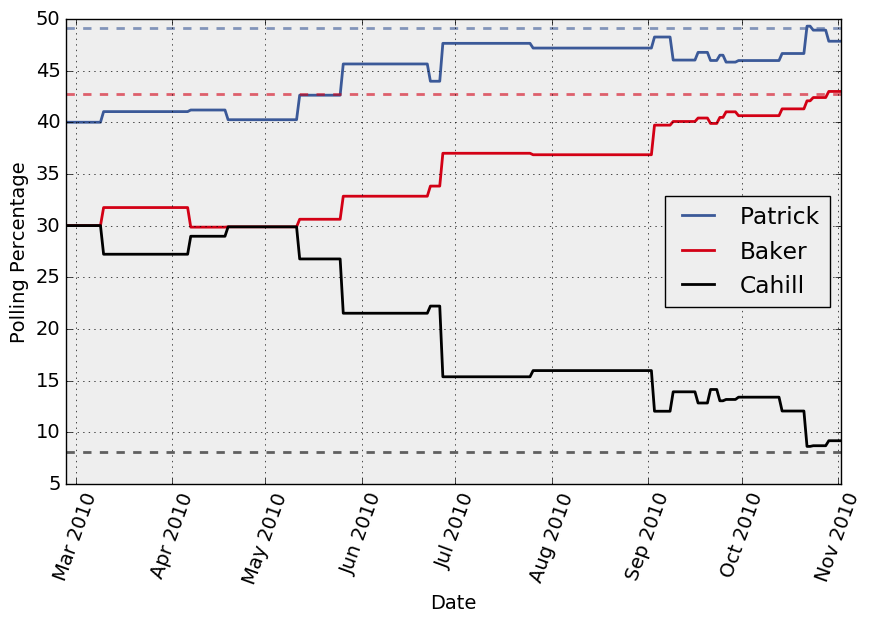

In [120]:
def id_from_url(url):
    """Given a URL, look up the RCP identifier number"""
    return url.split('-')[-1].split('.html')[0]


def plot_race(url):
    """Make a plot summarizing a senate race
    
    Overplots the actual race results as dashed horizontal lines
    """
    #hey, thanks again for these functions!
    id = id_from_url(url)
    xml = get_poll_xml(id)    
    colors = plot_colors(xml)

    if len(colors) == 0:
        return
    
    #really, you shouldn't have
    result = race_result(url)
    
    poll_plot(id)
    plt.xlabel("Date")
    plt.ylabel("Polling Percentage")
    for r in result:
        plt.axhline(result[r], color=colors[_strip(r)], alpha=0.6, ls='--')
        
plot_race('http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html')

Now that this is done, we can easily visualize many historical Governer races. The solid line plots the poll history, the dotted line reports the actual result.

If this code block fails, you probably have a bug in one of your functions.

In [119]:
page = requests.get('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html').text.encode('ascii', 'ignore')

for race in find_governor_races(page):
    plot_race(race)
    plt.show()

InvalidSchema: No connection adapters were found for '<!DOCTYPE html>
<html lang="en-us">
	<head>

		<meta charset="utf-8">

		<meta name="viewport" content="width=100, initial-scale=1, user-scalable=1">
		<meta http-equiv="cache-control" content="no-store, no-cache, must-revalidate" />
		<!--<meta http-equiv="Pragma" content="no-store, no-cache" />-->
		<meta http-equiv="Expires" content="0" />

		<meta property="og:title" content="2010 Governor Races | RealClearPolitics" />
		<meta property="og:description" content="2010 Governor Races" />
		<meta property="og:url" content="http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html" />
		<meta property="og:image" content="http://www.realclearpolitics.com/images/realclearpolitics_social_logo.png" />

		<title>RealClearPolitics - 2010 Election Maps - 2010 Governor Races</title>

		<link href="/epolls/styles/print.css" rel="stylesheet" type="text/css" media="print" />

		<link href="/assets/styles/epolls.css?v=3.2" rel="stylesheet" type="text/css" />
		<link href="http://assets.realclearpolitics.com/assets/styles/jquery.ui.all.css" media="screen" rel="stylesheet" type="text/css"/> 

		 <!-- LIQWID ADS --> 
		<script type="text/javascript">
			(function() {var s=document.createElement('script'); s.type='text/javascript'; s.async=true; s.src='//www.liqwid.net/?key=C80C-E818-A746-7402';var x=document.getElementsByTagName('script')[0];x.parentNode.insertBefore(s,x);})(); 
		</script>
		<!-- END OF LIQWID ADS -->

		<script src="http://assets.realclearpolitics.com/assets/scripts/yoshi.1.js" type="text/javascript"></script>
		<script type="text/javascript" src="/epolls/scripts/common.js?1"></script>


			<link rel="stylesheet" href="http://assets.realclearpolitics.com/styles/election_map.css" type="text/css" />
			<link rel="stylesheet" href="/assets/dev/styles/json_map.css" type="text/css" />
			<script type="text/javascript" src="/3rd_party/d3/3.4.8/d3.min.js" charset="utf-8"></script>
			<script type="text/javascript" src="/epolls/json/4_map_w_var.js"></script>
		
					<script type="text/javascript" src="http://www.realclearpolitics.com/assets/scripts/raphael.js"></script>

					<script type="text/javascript">
					  var scale = .6;
					  var default_file="/epolls/json/4_map_w_func.js";
					  var no_toss_up_file="/epolls/json/4_map_w_func_ntu.js";
					  var show_multiplier=false;
					  var editable=false;
					  var map_type=1;
					  var map_total=50;
					  var map_dem_not_up=7;
					  var map_gop_not_up=6;
					  var tooltip=false;
					  var show_labels=true;
					  var show_pickups = false;
					  var show_safe = false;
					</script>
				<style type="text/css">
					#alpha .pups_changes {
						margin-top: 0;
						margin-bottom: 0;
					}
				</style>
			<script type="text/javascript" src="/assets/scripts/usa_map_paths.js"></script>
				<script type="text/javascript" src="/assets/scripts/usa_map_init.js"></script>
				<script type="text/javascript" src="http://assets.realclearpolitics.com/scripts/swfobject.js"></script>
				<script src="/assets/scripts/amstock.js" type="text/javascript"></script><script src="/assets/scripts/race_changes_d3.js" type="text/javascript"></script>
			<script type="text/javascript">
			    var hash="";
			    var chart;
			    var stockPanel;
			    var graph;
			    var chart_data=[];
			    var candidate_name=[];
			    var candidate_color=[];
			    var last_date;
			    var pollster_name=[];
			    var pollster_id=[];
			    var data;
			    var first_date;
			    var final_date;
			    var zoom_periods=[{period:"DD", count:14, label:"7D"},{period:"DD", count:21, label:"14D"},{period:"DD", count:37, label:"30D"},{period:"MM", count:6, label:"6M"},{period:"YYYY", count:1, label:"1Y"},{period:"MAX", count:1, label:"MAX",selected:true}];
			  
			    var pid;
			    var chart_main_percent=63;
			    var chart_spread_percent=37;
			    var chart_spread_range=0;
			    
					var spread_chart=0;
					var tossup_chart=1;
			  </script>
			<style type="text/css">
			#chartLine {
			  height: 290px;
			  div#charttools { display: none; }
			}
			</style>
			<!--[if lt IE 9]>
			<script src="/assets/scripts/chart.main_DEV.js" type="text/javascript"></script>
			<![endif]-->
			<style>
			  #chartLine {
			    height: 290px;
			  }
			  div#charttools { display: none; }
			    #chartdiv {
			      position: relative;
			      overflow: hidden;
			    }
			    #chartdiv .plot,
			    #chartdiv2 .plot {
			      /*fill: rgba(250, 250, 255, 0.6);*/
			      fill: #f7f7f7;
			    }
			    #chartdiv .grid .tick,
			    #chartdiv2 .grid .tick {
			      stroke: #fff;
			      opacity: 0.7;
			    }
			    #chartdiv .grid path,
			    #chartdiv2 .grid path {
			      stroke-width: 0;
			    }
			    #chartdiv .axis path, #chartdiv .axis line,
			    #chartdiv2 .axis path, #chartdiv2 .axis line {
			      fill: none;
			      stroke: none;
			      shape-rendering: crispEdges;
			    }
			    #chartdiv .x.axis path,
			    #chartdiv2 .x.axis path {
			      display: none;
			    }
			    #chartdiv .d_line,
			    #chartdiv2 .d_line {
			      fill: none;
			      stroke: #3B5998;
			      stroke-width: 3px;
			    }
			    #chartdiv .r_line,
			    #chartdiv2 .r_line {
			      fill: none;
			      stroke: #D30015;
			      stroke-width: 3px;
			    }
			    #chartdiv .t_line,
			    #chartdiv2 .t_line {
			      fill: none;
			      stroke: #666;
			      stroke-width: 3px;
			    }
			    #chartdiv .d_circle,
			    #chartdiv2 .d_circle {
			      fill: #3B5998;
			      r: 6;
			    }
			    #chartdiv .r_circle,
			    #chartdiv2 .r_circle {
			      fill: #D30015;
			      r: 6;
			    }
			    #chartdiv .t_circle,
			    #chartdiv2 .t_circle {
			      fill: #666;
			      r: 6;
			    }
			    .clear-button {
			      font: 14px sans-serif;
			      cursor: pointer;
			      display: block;
			      text-align: center;
			      padding: 5px;
			      border: 1px solid #ccc;
			      margin: 0 10px 10px;
			    }
			    #chartdiv .brush .extent {
			      stroke: #fff;
			      fill-opacity: .125;
			      shape-rendering: crispEdges;
			    }
			    #chartdiv .verticalLine {
			      pointer-events: none;
			      stroke: #666;
			    }
			    #chartdiv .d_tooltip,
			    #chartdiv .r_tooltip,
			    #chartdiv .t_tooltip,
			    #chartdiv .date_tooltip,
			    #chartdiv .d_line,
			    #chartdiv .r_line,
			    #chartdiv .t_line,
			    #chartdiv .d_circle,
			    #chartdiv .r_circle,
			    #chartdiv .t_circle {
			      pointer-events: none;
			    }
			    #chartdiv .d_tooltip,
			    #chartdiv .r_tooltip,
			    #chartdiv .t_tooltip,
			    #chartdiv .date_tooltip {
			      display: block;
			      position: absolute;
			      padding: 5px;
			      -webkit-border-radius: 5px;
			      -moz-border-radius: 5px;
			      border-radius: 5px;
			      border: 2px solid #fff;
			      color: #fff;
			      opacity: 0;
			    }
			    #chartdiv .d_tooltip {
			      background: #3B5998;
			    }
			    #chartdiv .r_tooltip {
			      background: #D30015;
			    }
			    #chartdiv .t_tooltip {
			      background: #666;
			    }
			    #chartdiv .date_tooltip {
			      background: #D30015;
			      width: 80px;
			      text-align: center;
			    }
			    #chartdiv .graph_sep {
			      pointer-events: none;
			      stroke: #666;
			    }
			    #chartdiv .toss_ups {
			      pointer-events: none;
			      fill: #666;
			    }
			    #chartdiv .toss_ups_am_label {
			      pointer-events: none;
			      position: absolute;
			      left: 40px;
			      top: 143px;
			      color: #666;
			    }

			    html .clearfix {
					display: block;
				}
			    .changes.full_changes {
					margin: 0;
					border-top: none;
			    }
			    .changes table tr:nth-child(even) {
			    	background: #F1F1F1;
			    }
			    .changes table tr:nth-child(odd) {
			    	background: #fff;
			    }
			    .changes table.no_zebra > tbody > tr {
			    	background: #fff;
			    }
			    .changes table.no_zebra td.reset {
			    	border-left: 1px solid #ccc;
			    }
			    .changes table.no_zebra td.reset:first-child {
			    	border-left: none;
			    }
			    .changes table tr.view_full_race_changes {
			    	background: #fff;
			    }
			    .changes table tr.view_full_race_changes > td {
			    	text-align: right;
			    	font-size: 9px;
			    }
			    .ribbon.changes_ribbon {
			    	margin: 0;
			    }
			    .ribbon span.note.note_changes {
			    	height: 13px;
			    	margin-top: 5px;
			    	margin-bottom: -18px;
			    }
				.small_chart_container {
					border: 1px solid #CCC;
					background: url("/images/bg_election_chart.gif") repeat-x scroll center bottom #FFF;
					margin-top: 15px;
				}
				.small_chart_container h3 {
					color: #FFF;
					font: bold 10px Verdana,Arial,Helvetica,sans-serif;
					background: none repeat scroll 0% 0% #444;
					margin: 3px;
					padding: 4px;
					text-align: center;
					text-transform: uppercase;
				}
			  </style>
			
		<!-- Amazon Ads -->
		<script type='text/javascript' src='http://c.amazon-adsystem.com/aax2/amzn_ads.js'></script> 
		
		<script type='text/javascript'>
			try {
				amznads.getAds('3148');
			} catch(e) { /*ignore*/}
		</script>
		<script type='text/javascript'>
			var key = 'amznslots';
			var values = amznads.getTokens(); //comma separated tokens   
        </script>
        <!-- End Amazon Ads -->

		<script id="jsSite" data-site="politics" data-site-page="polls" src="/scripts/rc-load-widgets.js?v=6.0" type="text/javascript"></script>

	</head>
<body class="polls_maps polling">

<div id="container"><div id="map_tool_tip"></div><div id="map_zoom_out"></div><div id="map_district_squares"></div><div class="preload"><img src="http://www.realclearpolitics.com/images/bg_pickup_2_3.png" /><img src="http://www.realclearpolitics.com/images/bg_pickup_2_2.png" /><img src="http://www.realclearpolitics.com/images/bg_pickup_2_1.png" /><img src="http://www.realclearpolitics.com/images/bg_pickup_1_3.png" /><img src="http://www.realclearpolitics.com/images/bg_pickup_1_2.png" /><img src="http://www.realclearpolitics.com/images/bg_pickup_1_1.png" /></div><div id="masthead">

	<div id="page-header">

		<div id="page-header-logo">
			<a href="/"><img src="/dev/mt-static/images/logo-sub.gif" border="0" height="126" width="180" alt="RealClearPolitics"></a>
		</div>

		<div id="page-header-ad">

			<div id="ad-leaderboardtag">
				<img src="/dev/mt-static/images/leaderboard_tag.gif" alt="Advertisement" width="18" height="90" />
			</div>

		</div>

	</div>

	<link rel="stylesheet" href="/styles/menu.css" type="text/css" />
<script type="text/javascript" src="/scripts/menu_controls.js"></script>

    <div id="links_verticals" class="links_verticals">
      <ul class="links">
        <li class="site"><a data-name="polls" id="button_polls" href="http://www.realclearpolitics.com/epolls/latest_polls/" class="parent">Polls</a></li>
        <li class="site"><a data-name="elections_2014" id="button_elections_2014" href="http://www.realclearpolitics.com/elections/" class="parent">Election 2014</a></li>
        <li class="site"><a data-name="elections_2016" id="button_elections_2016" href="http://www.realclearpolitics.com/elections/2016/" class="parent">Election 2016</a></li>
        <li class="site"><a data-name="video" href="http://www.realclearpolitics.com/video/">Video</a></li>
        <li class="site"><a data-name="changing_lanes" href="http://www.realclearpolitics.com/video/changing_lanes/">Changing Lanes</a></li>
        <li class="site"><a data-name="writers" id="button_writers" href="javascript:void(0)" class="parent">Writers</a></li>
        <li class="site"><a data-name="cartoons" href="http://www.realclearpolitics.com/cartoons">Cartoons</a></li>
        <li class="site"><a data-name="links" id="button_links" href="javascript:void(0)" class="parent">Links</a></li>
        <li class="site"><a data-name="events" href="http://www.realclearpolitics.com/events/">Events</a></li>
        <li class="site short"><a data-name="more" id="button_more" href="javascript:void(0);" class="parent">More</a></li>		
        <li class="site long"><a href="http://www.realclearpolitics.com/daily_newsletters/">Newsletters</a></li>
        <li class="site long"><a href="http://www.realclearpolitics.com/twitter/">Twitter</a></li>	        
        <li class="site tools"><a data-name="tools" id="button_tools" href="javascript:void(0)" class="parent"><img src="http://www.realclearpolitics.com/images/menu_icons_v2.png" /></a></li>        
        
	  </ul>
    </div>
    <div id="links_verticals" class="links_verticals white">
      <ul class="links">       
       <li class="vertical vertical_2"><a style="font-weight:normal;" class="menu_button" id="button_policy" data-name="policy" href="http://www.realclearpolicy.com">Policy</a></li>
        <li class="vertical vertical_1"><a style="font-weight:normal;" class="menu_button" id="button_markets" data-name="markets" href="http://www.realclearmarkets.com">Markets</a></li>
        <li class="vertical vertical_3"><a style="font-weight:normal;" class="menu_button" id="button_world" data-name="world" href="http://www.realclearworld.com">World</a></li>
        <li class="vertical vertical_10"><a style="font-weight:normal;" class="menu_button" id="button_defense" data-name="defense" href="http://www.realcleardefense.com">Defense</a></li>
        <li class="vertical vertical_4"><a style="font-weight:normal;" class="menu_button" id="button_science" data-name="science" href="http://www.realclearscience.com">Science</a></li>
        <li class="vertical vertical_5"><a style="font-weight:normal;" class="menu_button" id="button_technology" data-name="technology" href="http://www.realcleartechnology.com">Tech</a></li>
        <li class="vertical vertical_6"><a style="font-weight:normal;" class="menu_button" id="button_history" data-name="history" href="http://www.realclearhistory.com">History</a></li>
        <li class="vertical vertical_7"><a style="font-weight:normal;" class="menu_button" id="button_religion" data-name="religion" href="http://www.realclearreligion.org">Religion</a></li>
        <li class="vertical vertical_11"><a style="font-weight:normal;" class="menu_button" id="button_sports" data-name="sports" href="http://www.realclearsports.com">Sports</a></li>
        <li class="vertical vertical_11"><a style="font-weight:normal;" class="menu_button" id="button_sports" data-name="sports" href="http://www.realcleareducation.com">Education</a></li>
        <li class="vertical vertical_11"><a style="font-weight:normal;" class="menu_button" id="button_sports" data-name="sports" href="http://www.realclearenergy.org">Energy</a></li>
        <li class="vertical vertical_11"><a style="font-weight:normal;" class="menu_button" id="button_sports" data-name="sports" href="http://www.realclearbooks.com">Books</a></li>        
      </ul>
    </div>
    <ul class="submenu" id="submenu_polls" data-name="polls">
      <li><a href="http://www.realclearpolitics.com/epolls/latest_polls/">Latest Polls</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/2016/president/us/2016_democratic_presidential_nomination-3824.html">Dem Nomination</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/2016/president/us/2016_republican_presidential_nomination-3823.html">GOP Nomination</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/other/president_obama_job_approval-1044.html">Obama Job Approval</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/latest_polls/president/">President 2016</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/latest_polls/senate/">Senate 2016</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/latest_polls/governor/">Governors 2016</a></li>      
      <li><a href="http://www.realclearpolitics.com/epolls/other/obama_and_democrats_health_care_plan-1130.html">Health Care Law</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/latest_polls/elections/">All Election Polls</a></li>
    </ul>
    <ul class="submenu" id="submenu_elections_2014" data-name="elections_2014">
	  <li><a href="http://www.realclearpolitics.com/elections/">RCP Election 2014</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/election_2014/battle_for_congress.html">Battle for Congress</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/2014/senate/2014_elections_senate_map.html">Senate Map</a></li>                
      <li><a href="http://www.realclearpolitics.com/epolls/2014/house/2014_elections_house_map.html">House Map</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/2014/governor/2014_elections_governor_map.html">Governor Map</a></li> 
      <li><a href="http://www.realclearpolitics.com/video/election_2014_ads/">Campaign Ads</a></li>
      <li><a href="http://www.realclearpolitics.com/elections/election_dates/">Election Calendar</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/latest_polls/elections/">Latest 2014 Polls</a></li>
    </ul>
    <ul class="submenu" id="submenu_elections_2016" data-name="elections_2016">
	  <li><a href="http://www.realclearpolitics.com/elections/2016/">RCP Election 2016</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/latest_polls/president/ ">Latest 2016 Polls</a></li>            
      <li><a href="http://www.realclearpolitics.com/epolls/2016/president/us/2016_democratic_presidential_nomination-3824.html">Democratic Nomination</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/2016/president/us/2016_republican_presidential_nomination-3823.html">Republican Nomination</a></li>                
      <li><a href="http://www.realclearpolitics.com/epolls/2016/president/early_primary_state_polls.html ">Early Primary State Polls</a></li>
      <li><a href="http://www.realclearpolitics.com/epolls/2016/president/2016_presidential_race.html">General Election Match-Ups</a></li>
    </ul>    
    <ul class="submenu" id="submenu_writers" data-name="writers">
      <li><a href="http://www.realclearpolitics.com/authors/tom_bevan/">Tom Bevan</a></li>
      <li><a href="http://www.realclearpolitics.com/authors/carl_m_cannon">Carl M. Cannon</a></li>
      <li><a href="http://www.realclearpolitics.com/authors/lou_cannon/">Lou Cannon</a></li>
      <li><a href="http://www.realclearpolitics.com/authors/scott_conroy">Scott Conroy</a></li>
      <li><a href="http://www.realclearpolitics.com/authors/caitlin_huey-burns">Caitlin Huey-Burns</a></li>
      <li><a href="http://www.realclearpolitics.com/authors/adam_oneal/">Adam O'Neal</a></li>
      <li><a href="http://www.realclearpolitics.com/authors/mark_salter/">Mark Salter</a></li>
      <li><a href="http://www.realclearpolitics.com/authors/alexis_simendinger">Alexis Simendinger</a></li>
      <li><a href="http://www.realclearpolitics.com/authors/sean_trende">Sean Trende</a></li>
      <li><a href="http://www.realclearpolitics.com/authors/heather_wilhelm/">Heather Wilhelm</a></li>
      <li><a href="http://www.realclearpolitics.com/authors/cathy_young/">Cathy Young</a></li>
    </ul>    
    <ul class="submenu" id="submenu_links" data-name="links">
      <li><a href="http://www.realclearpolitics.com/links.html#newspapers">Newspapers</a></li>
      <li><a href="http://www.realclearpolitics.com/links.html#magazines">Magazines</a></li>
      <li><a href="http://www.realclearpolitics.com/links.html#columnists">Columnists & Blogs</a></li>
      <li><a href="http://www.realclearpolitics.com/links.html#electronic">Electronic Media</a></li>
    </ul> 
    <ul class="submenu" id="submenu_more" data-name="more">
      <li><a href="http://www.realclearpolitics.com/twitter">Twitter</a></li>
      <li><a href="http://www.realclearpolitics.com/daily_newsletters/">Newsletters</a></li>
    </ul>          
    <ul class="submenu" id="submenu_tools" data-name="tools">
      <li><iframe src="//www.facebook.com/plugins/like.php?href=https%3A%2F%2Fwww.facebook.com%2Fpages%2FRealClearPolitics%2F27088225427%3Fv%3Dwall&width=150&layout=button_count&action=like&show_faces=false&share=false&height=21&appId=281527658527715" scrolling="no" frameborder="0" style="border:none; overflow:hidden; width:100px; height:21px;" allowTransparency="true"></iframe></li>
      <li><iframe allowtransparency="true" frameborder="0" scrolling="no" src="//platform.twitter.com/widgets/follow_button.html?screen_name=RealClearNews&show_screen_name=false" style="width:150px; height:20px;"></iframe></li>            
      <li>
			<form method="get" action="http://www.realclearpolitics.com/search/">                
                <input id="search" class="rcmenu_toolbarsearch" onfocus="if(!this.emptied) { this.value = ''; this.emptied = 1; }" value="Search RealClearPolitics" size="20" name="q"/>
                <input type="image" align="absmiddle" src="/images/next-arrow.png"/>                
                        </form>
			 

      </li>
    </ul>
    <div class="clear"></div></div>
<div id="gamma">

	<div id="leftbox-latest"><span class="sidebar-header">State of the Union</span><div id="poll_sidebar"><p><strong><span><a href="https://owa.mse5.exchange.ms/exchweb/bin/redir.asp?URL=http://www.realclearpolitics.com/epolls/other/congressional_job_approval-903.html" target="_blank"><span> </span></a></span></strong><strong><img src="http://www.realclearpolitics.com/mt-static/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/other/president_obama_job_approval-1044.html">Obama Job Approval</a></strong><strong><br /></strong><strong><img src="http://www.realclearpolitics.com/mt-static/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/other/congressional_job_approval-903.html">Congressional Job Approval</a></strong><strong><br /></strong><strong><img src="http://www.realclearpolitics.com/mt-static/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/other/direction_of_country-902.html">Direction of Country</a></strong><strong><br /><strong><img src="http://www.realclearpolitics.com/mt-static/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/latest_polls/state_of_the_union/">Latest State of Union Polls</a></strong></strong></p></div></div><div id="leftbox-latest"><span class="sidebar-header">2010 Senate Races</span><div id="poll_sidebar"><p><strong><img src="http://www.realclearpolitics.com/mt-static/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/2010/senate/2010_elections_senate_map.html">RealClearPolitics Ratings</a></strong><br /> <strong><img src="http://www.realclearpolitics.com/mt-static/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/2010/senate/2010_elections_senate_map_race_changes.html">RCP Race-by-Race Changes</a></strong><br /> <strong><img src="http://www.realclearpolitics.com/mt-static/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/2010/senate/2010_elections_senate_map_final_results.html">Final Senate Map</a></strong><br /> <select class="search_by_race" name="search_by_race"> <option value="#">Senate Races</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/al/alabama_senate_shelby_vs_barnes-1430.html">Alabama Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/ak/alaska_senate_miller_vs_mcadams_vs_murkowski-1700.html">Alaska Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/az/arizona_senate_mccain_vs_glassman-1433.html">Arizona Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/ar/arkansas_senate_boozman_vs_lincoln-1186.html">Arkansas Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/ca/california_senate_boxer_vs_fiorina-1094.html">California Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/co/colorado_senate_buck_vs_bennet-1106.html">Colorado Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/ct/connecticut_senate_mcmahon_vs_blumenthal-1145.html">Connecticut Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/de/delaware_senate_oadonnell_vs_coons-1670.html">Delaware Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/fl/florida_senate_rubio_vs_meek_vs_crist-1456.html">Florida Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/ga/georgia_senate_isakson_vs_thurmond-1477.html">Georgia Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/hi/hawaii_senate_cavasso_vs_inouye-1726.html">Hawaii Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/id/idaho_senate_crapo_vs_sullivan-1525.html">Idaho Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/il/illinois_senate_giannoulias_vs_kirk-1092.html">Illinois Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/in/indiana_senate_coats_vs_ellsworth-1209.html">Indiana Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/ia/iowa_senate_grassley_vs_conlin-1217.html">Iowa Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/ks/kansas_senate_moran_vs_johnston-1520.html">Kansas Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/ky/kentucky_senate_paul_vs_conway-1148.html">Kentucky Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/la/louisiana_senate_vitter_vs_melancon-1095.html">Louisiana Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/md/maryland_senate_wargotz_vs_mikulski-1665.html">Maryland Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/mo/missouri_senate_blunt_vs_carnahan-1066.html">Missouri Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/nv/nevada_senate_angle_vs_reid-1517.html">Nevada Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/nh/new_hampshire_senate_ayotte_vs_hodes-1093.html">New Hampshire Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/ny/new_york_senate_dioguardi_vs_gillibrand-1469.html">New York Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/ny/new_york_senate_townsend_vs_schumer-1506.html">New York2 Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/nc/north_carolina_senate_burr_vs_marshall-1111.html">North Carolina Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/nd/north_dakota_senate_hoeven_vs_potter-1419.html">North Dakota Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/oh/ohio_senate_portman_vs_fisher-1069.html">Ohio Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/ok/oklahoma_senate_coburn_vs_rogers-1648.html">Oklahoma Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/or/oregon_senate_huffman_vs_wyden-1207.html">Oregon Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/pa/pennsylvania_senate_sestak_vs_toomey-1059.html">Pennsylvania Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/2010_elections_senate_map.html">South Carolina Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/2010_elections_senate_map.html">South Dakota Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/ut/utah_senate_lee_vs_granato-1626.html">Utah Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/vt/vermont_senate_britton_vs_leahy-1625.html">Vermont Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/wa/washington_senate_rossi_vs_murray-1183.html">Washington Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/wv/west_virginia_senate_special_election_raese_vs_manchin-1673.html">West Virginia Senate</option> <option value="http://www.realclearpolitics.com/epolls/2010/senate/wi/wisconsin_senate_feingold_vs_johnson-1577.html">Wisconsin Senate</option> </select></p></div></div><div id="leftbox-latest"><span class="sidebar-header">2010 House Races</span><div id="poll_sidebar"><p><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/2010/house/2010_elections_house_map.html">RealClearPolitics Ratings</a></strong><br /><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/2010/house/2010_elections_house_map_race_changes.html">RCP Race-by-Race Changes</a></strong><br /> <strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/other/generic_congressional_vote-901.html">Generic Congressional Ballot</a></strong><br /> <strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/2010/house/2010_elections_house_map_final_results.html"><strong>Final House Map</strong></a><strong></strong> <br /> </strong> <select class="search_by_race" name="search_by_race"> <option value="#">House Races</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/al/alabama_2nd_district_roby_vs_bright-1272.html">Alabama 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/al/alabama_5th_district_brooks_vs_raby-1370.html">Alabama 5th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ar/arkansas_1st_district_crawford_vs_causey-1261.html">Arkansas 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ar/arkansas_2nd_district_griffin_vs_elliott-1253.html">Arkansas 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ar/arkansas_4th_district_rankin_vs_ross-1343.html">Arkansas 4th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/az/arizona_1st_district_gosar_vs_kirkpatrick-1289.html">Arizona 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/az/arizona_3rd_district_quayle_vs_hulburd-1369.html">Arizona 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/az/arizona_5th_district_schweikert_vs_mitchell-1285.html">Arizona 5th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/az/arizona_7th_district_mcclung_vs_grijalva-1717.html">Arizona 7th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/az/arizona_8th_district_kelly_vs_giffords-1287.html">Arizona 8th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ca/california_11th_district_harmer_vs_mcnerney-1296.html">California 11th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ca/california_18th_district_berryhill_vs_cardoza-1371.html">California 18th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ca/california_20th_district_vidak_vs_costa-1344.html">California 20th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ca/california_3rd_district_lungren_vs_bera-1248.html">California 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ca/california_45th_district_mack_vs_pougnet-1250.html">California 45th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ca/california_47th_district_tran_vs_sanchez-1303.html">California 47th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/co/colorado_3rd_district_tipton_vs_salazar-1295.html">Colorado 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/co/colorado_4th_district_gardner_vs_markey-1258.html">Colorado 4th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/co/colorado_7th_district_frazier_vs_perlmutter-1345.html">Colorado 7th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ct/connecticut_1st_district_brickley_vs_larson-1713.html">Connecticut 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ct/connecticut_2nd_district_peckinpaugh_vs_courtney-1715.html">Connecticut 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ct/connecticut_4th_district_debicella_vs_himes-1346.html">Connecticut 4th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ct/connecticut_5th_district_caligiuri_vs_murphy-1304.html">Connecticut 5th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/de/delaware_atlarge_carney_vs_urquhart-1681.html">Delaware At-Large</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/fl/florida_12th_district_ross_vs_edwards-1364.html">Florida 12th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/fl/florida_2nd_district_southerland_vs_boyd-1372.html">Florida 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/fl/florida_22nd_district_west_vs_klein-1342.html">Florida 22nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/fl/florida_24th_district_adams_vs_kosmas-1281.html">Florida 24th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/fl/florida_25th_district_rivera_vs_garcia-1366.html">Florida 25th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/fl/florida_8th_district_webster_vs_grayson-1254.html">Florida 8th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ga/georgia_12th_district_mckinney_vs_barrow-1353.html">Georgia 12th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ga/georgia_2nd_district_keown_vs_bishop-1674.html">Georgia 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ga/georgia_8th_district_scott_vs_marshall-1305.html">Georgia 8th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/hi/hawaii_1st_district_djou_vs_hanabusa-1566.html">Hawaii 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ia/iowa_1st_district_lange_vs_braley-1373.html">Iowa 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ia/iowa_2nd_district_millermeeks_vs_loebsack-1680.html">Iowa 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ia/iowa_3rd_district_zaun_vs_boswell-1306.html">Iowa 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/id/idaho_1st_district_labrador_vs_minnick-1266.html">Idaho 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/il/illinois_10th_district_dold_vs_seals-1284.html">Illinois 10th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/il/illinois_11th_district_kinzinger_vs_halvorson-1347.html">Illinois 11th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/il/illinois_14th_district_hultgren_vs_foster-1282.html">Illinois 14th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/il/illinois_17th_district_schilling_vs_hare-1458.html">Illinois 17th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/il/illinois_8th_district_walsh_vs_bean-1354.html">Illinois 8th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/in/indiana_2nd_district_walorski_vs_donnelly-1348.html">Indiana 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/in/indiana_8th_district_bucshon_vs_van_haaften-1387.html">Indiana 8th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/in/indiana_9th_district_young_vs_hill-1165.html">Indiana 9th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ks/kansas_3rd_district_yoder_vs_moore-1255.html">Kansas 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ky/kentucky_3rd_district_lally_vs_yarmuth-1374.html">Kentucky 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ky/kentucky_6th_district_barr_vs_chandler-1349.html">Kentucky 6th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/la/louisiana_2nd_district_cao_vs_richmond-1301.html">Louisiana 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/la/louisiana_3rd_district_landry_vs_sangisetty-1247.html">Louisiana 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ma/massachusetts_10th_district_perry_vs_keating-1350.html">Massachusetts 10th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ma/massachusetts_4th_district_bielat_vs_frank-1706.html">Massachusetts 4th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ma/massachusetts_5th_district_golnik_vs_tsongas-1688.html">Massachusetts 5th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ma/massachusetts_6th_district_hudak_vs_tierney-1459.html">Massachusetts 6th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/md/maryland_1st_district_harris_vs_kratovil-1256.html">Maryland 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/me/maine_1st_district_scontras_vs_pingree-1460.html">Maine 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/me/maine_2nd_district_michaud_v_levesque-1687.html">Maine 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/mi/michigan_1st_district_benishek_vs_mcdowell-1468.html">Michigan 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/mi/michigan_15th_district_steele_vs_dingell-1699.html">Michigan 15th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/mi/michigan_7th_district_walberg_vs_schauer-1259.html">Michigan 7th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/mi/michigan_9th_district_raczkowski_vs_peters-1375.html">Michigan 9th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/mn/minnesota_1st_district_demmer_vs_walz-1376.html">Minnesota 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/mn/minnesota_6th_district_bachmann_vs_clark_vs_anderson-1367.html">Minnesota 6th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/mn/minnesota_7th_district_byberg_vs_peterson-1728.html">Minnesota 7th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/mn/minnesota_8th_district_cravaack_vs_oberstar-1712.html">Minnesota 8th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/mo/missouri_3rd_district_martin_vs_carnahan-1377.html">Missouri 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/mo/missouri_4th_district_hartzler_vs_skelton-1292.html">Missouri 4th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ms/mississippi_1st_district_nunnelee_vs_childers-1270.html">Mississippi 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ms/mississippi_2nd_district_marcy_vs_thompson-1707.html">Mississippi 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ms/mississippi_4th_district_palazzo_vs_taylor-1461.html">Mississippi 4th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nc/north_carolina_11th_district_miller_vs_shuler-1379.html">North Carolina 11th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nc/north_carolina_13th_district_randall_vs_miller-1729.html">North Carolina 13th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nc/north_carolina_2nd_district_ellmers_vs_etheridge-1462.html">North Carolina 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nc/north_carolina_4th_district_lawson_vs_price-1696.html">North Carolina 4th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nc/north_carolina_7th_district_pantano_vs_mcintyre-1675.html">North Carolina 7th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nc/north_carolina_8th_district_johnson_vs_kissell-1220.html">North Carolina 8th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nd/north_dakota_atlarge_berg_vs_pomeroy-1262.html">North Dakota At-Large</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ne/nebraska_2nd_district_terry_vs_white-1251.html">Nebraska 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nh/new_hampshire_1st_district_guinta_vs_sheaporter-1260.html">New Hampshire 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nh/new_hampshire_2nd_district_bass_vs_kuster-1491.html">New Hampshire 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nj/new_jersey_12th_district_sipprelle_vs_holt-1467.html">New Jersey 12th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nj/new_jersey_3rd_district_runyan_vs_adler-1307.html">New Jersey 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nj/new_jersey_6th_district_little_vs_pallone-1689.html">New Jersey 6th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nm/new_mexico_1st_district_barela_vs_heinrich-1294.html">New Mexico 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nm/new_mexico_2nd_district_pearce_vs_teague-1257.html">New Mexico 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nm/new_mexico_3rd_district_lujan_vs_mullins-1313.html">New Mexico 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/nv/nevada_3rd_district_heck_vs_titus-1135.html">Nevada 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ny/new_york_1st_district_altschuler_vs_bishop-1167.html">New York 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ny/new_york_13th_district_grimm_vs_mcmahon-1291.html">New York 13th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ny/new_york_19th_district_hayworth_vs_hall-1275.html">New York 19th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ny/new_york_2nd_district_gomez_vs_israel-1723.html">New York 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ny/new_york_20th_district_gibson_vs_murphy-1297.html">New York 20th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ny/new_york_22nd_district_phillips_vs_hinchey-1719.html">New York 22nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ny/new_york_23rd_district_doheny_vs_owens-1279.html">New York 23rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ny/new_york_24th_district_hanna_vs_arcuri-1280.html">New York 24th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ny/new_york_25th_district_buerkle_vs_maffei-1378.html">New York 25th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ny/new_york_27th_district_roberto_vs_higgins-1724.html">New York 27th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ny/new_york_29th_district_reed_vs_zeller-1336.html">New York 29th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ny/new_york_4th_district_becker_vs_mccarthy-1718.html">New York 4th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/oh/ohio_1st_district_chabot_vs_driehaus-1166.html">Ohio 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/oh/ohio_10th_district_corrigan_vs_kucinich-1722.html">Ohio 10th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/oh/ohio_12th_district_tiberi_vs_brooks-1368.html">Ohio 12th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/oh/ohio_13th_district_ganley_vs_sutton-1388.html">Ohio 13th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/oh/ohio_15th_district_stivers_vs_kilroy-1252.html">Ohio 15th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/oh/ohio_16th_district_renacci_vs_boccieri-1290.html">Ohio 16th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/oh/ohio_18th_district_gibbs_vs_space-1267.html">Ohio 18th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/oh/ohio_6th_district_johnson_vs_wilson-1380.html">Ohio 6th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ok/oklahoma_2nd_district_thompson_vs_boren-1463.html">Oklahoma 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/or/oregon_1st_district_cornilles_vs_wu-1381.html">Oregon 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/or/oregon_4th_district_defazio_v_robinson-1686.html">Oregon 4th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/or/oregon_5th_district_bruun_vs_schrader-1352.html">Oregon 5th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/pa/pennsylvania_10th_district_marino_vs_carney-1389.html">Pennsylvania 10th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/pa/pennsylvania_11th_district_barletta_vs_kanjorski-1299.html">Pennsylvania 11th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/pa/pennsylvania_12th_district_burns_vs_critz-1682.html">Pennsylvania 12th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/pa/pennsylvania_13th_district_adcock_vs_schwartz-1721.html">Pennsylvania 13th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/pa/pennsylvania_15th_district_dent_vs_callahan-1264.html">Pennsylvania 15th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/pa/pennsylvania_17th_district_argall_vs_holden-1308.html">Pennsylvania 17th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/pa/pennsylvania_3rd_district_kelly_vs_dahlkemper-1293.html">Pennsylvania 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/pa/pennsylvania_4th_district_rothfus_vs_altmire-1298.html">Pennsylvania 4th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/pa/pennsylvania_6th_district_gerlach_vs_trivedi-1271.html">Pennsylvania 6th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/pa/pennsylvania_7th_district_meehan_vs_lentz-1268.html">Pennsylvania 7th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/pa/pennsylvania_8th_district_fitzpatrick_vs_murphy-1278.html">Pennsylvania 8th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ri/rhode_island_1st_district_loughlin_vs_cicilline-1685.html">Rhode Island 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/sc/south_carolina_5th_district_mulvaney_vs_spratt-1222.html">South Carolina 5th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/sd/south_dakota_atlarge_noem_vs_herseth_sandlin-1421.html">South Dakota At-Large</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/tn/tennessee_4th_district_desjarlais_vs_davis-1382.html">Tennessee 4th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/tn/tennessee_5th_district_cooper_v_hall-1684.html">Tennessee 5th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/tn/tennessee_6th_district_black_vs_carter-1246.html">Tennessee 6th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/tn/tennessee_8th_district_fincher_vs_herron-1265.html">Tennessee 8th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/tx/texas_15th_district_zamora_vs_hinojosa-1727.html">Texas 15th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/tx/texas_17th_district_flores_vs_edwards-1277.html">Texas 17th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/tx/texas_23rd_district_canseco_vs_rodriguez-1383.html">Texas 23rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/tx/texas_25th_district_campbell_vs_doggett-1725.html">Texas 25th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/tx/texas_27th_district_farenthold_vs_ortiz-1464.html">Texas 27th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/ut/utah_2nd_district_philpot_vs_matheson-1465.html">Utah 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/va/virginia_11th_district_fimian_vs_connolly-1286.html">Virginia 11th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/va/virginia_2nd_district_rigell_vs_nye-1273.html">Virginia 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/va/virginia_5th_district_hurt_vs_perriello-1189.html">Virginia 5th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/va/virginia_9th_district_griffith_vs_boucher-1390.html">Virginia 9th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/wa/washington_2nd_district_koster_vs_larsen-1384.html">Washington 2nd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/wa/washington_3rd_district_herrera_vs_heck-1276.html">Washington 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/wa/washington_8th_district_reichert_vs_delbene-1263.html">Washington 8th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/wa/washington_9th_district_muri_vs_smith-1466.html">Washington 9th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/wi/wisconsin_3rd_district_kapanke_vs_kind-1386.html">Wisconsin 3rd District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/wi/wisconsin_7th_district_duffy_vs_lassa-1351.html">Wisconsin 7th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/wi/wisconsin_8th_district_ribble_vs_kagen-1309.html">Wisconsin 8th District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/wv/west_virginia_1st_district_mckinley_vs_oliverio-1288.html">West Virginia 1st District</option> <option value="http://www.realclearpolitics.com/epolls/2010/house/wv/west_virginia_3rd_district_maynard_vs_rahall-1385.html">West Virginia 3rd District</option> </select></p></div></div><div id="leftbox-latest"><span class="sidebar-header">2010 Governor Races</span><div id="poll_sidebar"><p><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html">RealClearPolitics Ratings</a></strong><br /> <strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map_race_changes.html">RCP Race-by-Race Changes</a></strong><br /> <strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map_final_results.html">Final Governors Map</a></strong><br /> <select class="search_by_race" name="search_by_race"> <option value="#">Governor Races</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/al/alabama_governor_bentley_vs_sparks-1586.html">Alabama Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ak/alaska_governor_parnell_vs_berkowitz-1510.html">Alaska Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/az/arizona_governor_brewer_vs_goddard-1409.html">Arizona Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html">Arkansas Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html">California Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/co/colorado_governor_maes_vs_hickenlooper_vs_tancredo-1677.html">Colorado Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ct/connecticut_governor_foley_vs_malloy-1357.html">Connecticut Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/fl/florida_governor_scott_vs_sink_vs_chiles-1607.html">Florida Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ga/georgia_governor_deal_vs_barnes-1316.html">Georgia Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/hi/hawaii_governor_aiona_vs_abercrombie-1163.html">Hawaii Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/id/idaho_governor_otter_vs_allred-1429.html">Idaho Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/il/illinois_governor_brady_vs_quinn-1361.html">Illinois Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ia/iowa_governor_branstad_vs_culver-1200.html">Iowa Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ks/kansas_governor_brownback_vs_holland-1235.html">Kansas Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/me/maine_governor_lepage_vs_mitchell_vs_cutler-1231.html">Maine Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/md/maryland_governor_ehrlich_vs_omalley-1121.html">Maryland Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html">Massachusetts Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/mi/michigan_governor_snyder_vs_bernero-1407.html">Michigan Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/mn/minnesota_governor_emmer_vs_dayton_vs_horner-1393.html">Minnesota Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ne/nebraska_governor_heineman_vs_meister-1695.html">Nebraska Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/nv/nevada_governor_sandoval_vs_reid-1137.html">Nevada Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/nh/new_hampshire_governor_stephen_vs_lynch-1446.html">New Hampshire Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/nm/new_mexico_governor_martinez_vs_denish-1323.html">New Mexico Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ny/new_york_governor_paladino_vs_cuomo-1423.html">New York Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/oh/ohio_governor_kasich_vs_strickland-1078.html">Ohio Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ok/oklahoma_governor_fallin_vs_askins-1236.html">Oklahoma Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/or/oregon_governor_dudley_vs_kitzhaber-1088.html">Oregon Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/pa/pennsylvania_governor_corbett_vs_onorato-1333.html">Pennsylvania Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ri/rhode_island_governor_chafee_vs_caprio_vs_robitaille-1232.html">Rhode Island Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/sc/south_carolina_governor_haley_vs_sheheen-1574.html">South Carolina Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/sd/south_dakota_governor_daugaard_vs_heidepriem-1310.html">South Dakota Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/tn/tennessee_governor_haslam_vs_mcwherter-1416.html">Tennessee Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/tx/texas_governor_perry_vs_white-1194.html">Texas Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/ut/utah_governor_special_election_herbert_vs_corroon-1454.html">Utah Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/vt/vermont_governor_dubie_vs_shumlin-1228.html">Vermont Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/wi/wisconsin_governor_walker_vs_barrett-1184.html">Wisconsin Governor</option> <option value="http://www.realclearpolitics.com/epolls/2010/governor/wy/wyoming_governor_mead_vs_peterson-1627.html">Wyoming Governor</option> </select></p></div></div><div id="leftbox-latest"><span class="sidebar-header">Senate 2010 Polls</span><div id="poll_sidebar"><script type="text/javascript" src="/epolls/2010/senate/1_left_column.js"></script></div></div><div id="leftbox-latest"><span class="sidebar-header">RCP Election 2009</span><div id="poll_sidebar"><p><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /></strong><strong><a href="http://www.realclearpolitics.com/epolls/2009/governor/va/virginia_governor_mcdonnell_vs_deeds-1055.html">Virginia Governor</a><br /></strong><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/2009/governor/nj/new_jersey_governor_corzine_vs_christie-1051.html">New Jersey Governor</a></strong></p></div></div><div id="leftbox-latest"><span class="sidebar-header">RCP Election 2008</span><div id="poll_sidebar"><p><strong>General Election<br /></strong><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /></strong><strong></strong><strong><a href="http://www.realclearpolitics.com/epolls/2008/president/us/general_election_mccain_vs_obama-225.html" target="_blank">Final
RCP Average &amp; Result</a></strong><strong></strong><br /><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /></strong><a href="http://www.realclearpolitics.com/epolls/maps/obama_vs_mccain/"><strong><span>Final Electoral
College Map</span></strong></a><br /><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/2008/president/battleground.html">State by State Results</a></strong><strong><span class="sidebar"><br /></span></strong><span class="sidebar"><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /></strong></span><strong><span class="sidebar"><a href="http://www.realclearpolitics.com/epolls/2008/senate/election_2008_senate_races.html">RCP Senate Avgs &amp; Results</a><br /></span></strong><span class="sidebar"><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /></strong></span><strong><span class="sidebar"><a href="http://www.realclearpolitics.com/epolls/2008/governor/election_2008_governor_races.html">RCP Gov Avgs &amp; Results</a><br /></span></strong><span class="sidebar"><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /></strong></span><strong><span class="sidebar"><a href="http://www.realclearpolitics.com/epolls/election_2008/key_house_results.html">Key House Results</a><br /></span>Nomination Fight<br /></strong><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /></strong><strong></strong><strong><a href="http://www.realclearpolitics.com/epolls/2008/president/democratic_delegate_count.html" target="_blank">Democratic
Delegate Count</a></strong><strong></strong><br /><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /></strong><strong><span><a href="http://www.realclearpolitics.com/epolls/2008/president/dem_results.html" target="_blank">Final
Democratic Results</a></span></strong><strong><span><a href="https://owa.mse5.exchange.ms/exchweb/bin/redir.asp?URL=http://www.realclearpolitics.com/epolls/2008/president/republican_delegate_count.html" target="_blank"></a><a href="https://owa.mse5.exchange.ms/exchweb/bin/redir.asp?URL=http://www.realclearpolitics.com/epolls/2008/president/republican_delegate_count.html" target="_blank"></a></span></strong><br /><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /></strong><strong></strong><strong><strong><a href="http://www.realclearpolitics.com/epolls/2008/president/democratic_vote_count.html" target="_blank"><strong><span>Democratic
Popular Vote</span></strong></a></strong></strong><strong></strong><br /><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /></strong><strong><span><strong></strong></span></strong><strong><strong><a href="http://www.realclearpolitics.com/epolls/2008/president/republican_delegate_count.html" target="_blank">Republican
Delegate Count</a></strong></strong><strong><strong></strong></strong><strong></strong><br /><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /></strong><strong><span><a href="http://www.realclearpolitics.com/epolls/2008/president/gop_results.html" target="_blank">Final
Republican Results</a></span></strong><strong></strong><br /><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /></strong><strong></strong><strong><a href="http://www.realclearpolitics.com/epolls/2008/president/republican_vote_count.html" target="_blank">Republican
Popular Vote</a></strong><strong></strong></p></div></div><div id="leftbox-latest"><span class="sidebar-header">RCP Election 2006 & 2004</span><div id="poll_sidebar"><div id="poll_sidebar"><strong>RealClearPolitics 2006</strong></div>
<div id="poll_sidebar"><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/writeup/2006_senate_realclearpolitics_poll_averages-63.html"><strong>RCP Sen Avgs &amp; Results</strong></a><br /><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><strong><a href="http://www.realclearpolitics.com/epolls/writeup/election_2006_governor_scorecard-62.html">RCP Gov Avgs &amp; Results<br /></a></strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/epolls/2006/house/us/generic_congressional_ballot-22.html"><strong>RCP Final Generic Avg</strong></a><br /><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><strong><a href="http://www.realclearpolitics.com/epolls/writeup/election_2006_key_house_results-55.html">Key House Results</a></strong></div>
<div id="poll_sidebar"><strong>RealClearPolitics 2004</strong><br /></div>
<div id="poll_sidebar"><strong><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/bush_vs_kerry.html">Final RCP Poll Average</a><br /><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/Presidential_04/chart3way.html">Final Bush-Kerry Graph</a><br /><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/Presidential_04/RCP_Electoral_Count_Final.html">Final Electoral Projection</a><br /><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/Presidential_04/2004_County_Results_Final.html">Map of Results by County</a><br /><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/bush_vs_kerry_sbys.html">Battleground State Avgs</a><br /><img src="http://assets.realclearpolitics.com/images/arrow_black.gif" border="0" alt="" width="7" height="10" /><a href="http://www.realclearpolitics.com/Senate.html">RCP Senate Averages</a></strong></div></div></div>
	<div id="leftbox-latest"><span class="sidebar-header">News &amp; Election Videos</span>
		<script type="text/javascript" src="http://www.realclearpolitics.com/video/recentvideoposts.js"></script>
	</div>

	<script type="text/javascript" src="http://www.realclearpolitics.com/rss/poll_widget2.js"></script>

	<div id="ad-home-left-box"></div>

</div>
<div id="alpha"><input type="hidden" value="4_map" name="poll_id" id="poll_id" data-maptype="1" data-race-id="0" />
			<input type="hidden" value="50" name="poll_data_table_increment" id="poll_data_table_increment" />
			<input type="hidden" value="" name="clean_poll_title" id="clean_poll_title" /><div class="barra_social">

	<div class="left toolset" ref="http://www.realclearpolitics.comhttp://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html" title="2010 Governor Races"></div>

	<div class="right">

		<label>Search by Race: </label>

		<script type="text/javascript" src="/epolls/2010/widget/search_by_race.js"></script>

	</div>

	<div class="clear"></div>

</div><div id="map-header" class="clearfix"><h2><span>2010</span> <span>G</span>overnor <span>R</span>aces</h2><p class="count"><span>Current Governors:</span> 26 Democrats | 24 Republicans</p>
<p class="links"><a href="../../../../epolls/2010/senate/2010_elections_senate_map.html">RCP Senate</a> &middot; <a href="../../../../epolls/2010/senate/2010_elections_senate_map_final_results.html">Final Senate</a> &middot; <a href="../../../../epolls/2010/house/2010_elections_house_map.html">RCP House</a> &middot; <a href="../../../../epolls/2010/house/2010_elections_house_map_final_results.html">Final House</a> &middot; <a href="../../../../epolls/2010/governor/2010_elections_governor_map.html" class="on">RCP Governors</a> &middot; <a href="../../../../epolls/2010/governor/2010_elections_governor_map_final_results.html">Final Govs</a></p></div>
        <div id="map-scorecard" class="clearfix" style="display:block;">
			<table class="container" cellpadding="0" cellspacing="0" border="0">
				<tr>
					<td class="dem">
						<table cellpadding="0" cellspacing="0" border="0">
							<tr>
								<td class="seats">12</td>
								<td class="party">Democrats</td>
							</tr>
						</table>
					</td><td class="tossup">
							<table cellpadding="0" cellspacing="0" border="0">
								<tr>
									<td style=" text-align: center; font-size: 10px;">Toss Ups<br /><span style=" font-size: 28px; font-weight: bold; line-height: 1;">11</span></td>
								</tr>
							</table>
						</td><td class="gop">
						<table cellpadding="0" cellspacing="0" border="0">
							<tr>
								<td class="party">Republicans</td>
								<td class="seats">27</td>
							</tr>
						</table>
					</td>
				</tr>
			</table>
		</div>
			<style type="text/css">
				.ribbon td.dem_safe   { width: 14%; }
				.ribbon td.dem_likely { width: 6%; }
				.ribbon td.dem_lean   { width: 4%; }
				.ribbon td.toss_up    { width: 22%; }
				.ribbon td.gop_lean   { width: 14%; }
				.ribbon td.gop_likely { width: 10%; }
				.ribbon td.gop_safe   { width: 30%; }
			</style>
			
			<div class="ribbon">
				<table border="0" cellpadding="0" cellspacing="0">
					<tr><td class="dem_safe">7 Safe or Not Up</td><td class="dem_likely">3</td><td class="dem_lean">2</td><td class="toss_up">11</td><td class="gop_lean">7</td><td class="gop_likely">5</td><td class="gop_safe">15 Safe or Not Up</td></tr>
				</table>
				<span class="note">26 State Houses Needed For Majority (<a href="#previous_changes">Recent Race Changes</a>)</span>
			</div><div id="mymap" class="clearfix " style="clear: both;"><div class="clearfix" id="states"><div class="states-in-play clearfix dem2"><table cellpadding="0" cellspacing="0" border="0"><tr><th>Likely Dem</th></tr><tr><td><a class="" href=""><span></span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html"><span>AR: Beebe (D)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/md/maryland_governor_ehrlich_vs_omalley-1121.html"><span>MD: O'Malley (D)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/ny/new_york_governor_paladino_vs_cuomo-1423.html"><span>NY: Open (D)</span></a></td></tr><tr><td class="safe"><a class="safe_seats" href="#safe_seats"><span>Safe Dem Seats</span></a></td></tr></table></div><div class="states-in-play clearfix dem3"><table cellpadding="0" cellspacing="0" border="0"><tr><th>Leans Dem</th></tr><tr><td><a class="" href=""><span></span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html"><span>CA: Open (R)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/nh/new_hampshire_governor_stephen_vs_lynch-1446.html"><span>NH: Lynch (D)</span></a></td></tr></table></div><div class="states-in-play clearfix tu"><table cellpadding="0" cellspacing="0" border="0"><tr><th>Toss Up</th></tr><tr><td><a class="" href="/epolls/2010/governor/co/colorado_governor_maes_vs_hickenlooper_vs_tancredo-1677.html"><span>CO: Open (D)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/ct/connecticut_governor_foley_vs_malloy-1357.html"><span>CT: Open (R)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/fl/florida_governor_scott_vs_sink_vs_chiles-1607.html"><span>FL: Open (R)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/hi/hawaii_governor_aiona_vs_abercrombie-1163.html"><span>HI: Open (R)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/il/illinois_governor_brady_vs_quinn-1361.html"><span>IL: Quinn (D)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html"><span>MA: Patrick (D)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/mn/minnesota_governor_emmer_vs_dayton_vs_horner-1393.html"><span>MN: Open (R)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/oh/ohio_governor_kasich_vs_strickland-1078.html"><span>OH: Strickland (D)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/or/oregon_governor_dudley_vs_kitzhaber-1088.html"><span>OR: Open (D)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/ri/rhode_island_governor_chafee_vs_caprio_vs_robitaille-1232.html"><span>RI: Open (R)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/vt/vermont_governor_dubie_vs_shumlin-1228.html"><span>VT: Open (R)</span></a></td></tr></table></div><div class="states-in-play clearfix gop3"><table cellpadding="0" cellspacing="0" border="0"><tr><th>Leans GOP</th></tr><tr><td><a class="" href=""><span></span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/az/arizona_governor_brewer_vs_goddard-1409.html"><span>AZ: Brewer (R)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/ga/georgia_governor_deal_vs_barnes-1316.html"><span>GA: Open (R)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/nm/new_mexico_governor_martinez_vs_denish-1323.html"><span>NM: Open (D)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/pa/pennsylvania_governor_corbett_vs_onorato-1333.html"><span>PA: Open (D)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/sc/south_carolina_governor_haley_vs_sheheen-1574.html"><span>SC: Open (R)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/tx/texas_governor_perry_vs_white-1194.html"><span>TX: Perry (R)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/wi/wisconsin_governor_walker_vs_barrett-1184.html"><span>WI: Open (D)</span></a></td></tr></table></div><div class="states-in-play clearfix gop2"><table cellpadding="0" cellspacing="0" border="0"><tr><th>Likely GOP</th></tr><tr><td><a class="" href=""><span></span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/ak/alaska_governor_parnell_vs_berkowitz-1510.html"><span>AK: Parnell (R)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/ia/iowa_governor_branstad_vs_culver-1200.html"><span>IA: Culver (D)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/me/maine_governor_lepage_vs_mitchell_vs_cutler-1231.html"><span>ME: Open (D)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/mi/michigan_governor_snyder_vs_bernero-1407.html"><span>MI: Open (D)</span></a></td></tr><tr><td><a class="" href="/epolls/2010/governor/nv/nevada_governor_sandoval_vs_reid-1137.html"><span>NV: Open (R)</span></a></td></tr><tr><td class="safe"><a class="safe_seats" href="#safe_seats"><span>Safe GOP Seats</span></a></td></tr></table></div></div><div id="map_loading"></div><div id="map_container"><div id="map_canvas"></div><div id="info"></div><div id="map-legend">
	            		<table cellpadding="0" cellspacing="0" border="0">
		            		<tr>
								<th  style="border-right: 1px solid #ccc;" colspan="2">Democrats</th>
								<th colspan="2">Republicans</th>
		                    </tr><tr>
									<td><img src="http://assets.realclearpolitics.com/images/dem-1.gif" /> Safe</td>
									<td style=""><img src="http://assets.realclearpolitics.com/images/dem-2.gif" /> Likely</td>
									
									<td style="padding-left: 4px;"><img src="http://assets.realclearpolitics.com/images/gop-1.gif" /> Safe</td>
									<td style="border-right: none;"><img src="http://assets.realclearpolitics.com/images/gop-2.gif" /> Likely</td>
								</tr>
								<tr>
									<td><img src="http://assets.realclearpolitics.com/images/dem-3.gif" /> Leans</td>
									<td style=""><img src="http://assets.realclearpolitics.com/images/toss-up.gif" /> Toss up</td>
									
									<td style="padding-left: 4px;"><img src="http://assets.realclearpolitics.com/images/gop-3.gif" /> Leans</td>
									<td style="border-right: none;"><img src="http://assets.realclearpolitics.com/images/toss-up.gif" /> Toss up</td>
								</tr><tr>
								<td class="pu" valign="top" colspan="2"><img src="http://assets.realclearpolitics.com/images/dpu.gif" /> Pick-ups
								 (<a target="_parent" href="/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html">CA</a>)</td>
								<td class="pu" style="border-right: none;padding-left: 4px;" valign="top" colspan="2"><img src="http://assets.realclearpolitics.com/images/gpu.gif" /> Pick-ups  (<a target="_parent" href="/epolls/2010/governor/nm/new_mexico_governor_martinez_vs_denish-1323.html">NM</a> &middot; <a target="_parent" href="/epolls/2010/governor/pa/pennsylvania_governor_corbett_vs_onorato-1333.html">PA</a> &middot; <a target="_parent" href="/epolls/2010/governor/wi/wisconsin_governor_walker_vs_barrett-1184.html">WI</a> &middot; <a target="_parent" href="/epolls/2010/governor/ia/iowa_governor_branstad_vs_culver-1200.html">IA</a> &middot; <a target="_parent" href="/epolls/2010/governor/me/maine_governor_lepage_vs_mitchell_vs_cutler-1231.html">ME</a> &middot; <a target="_parent" href="/epolls/2010/governor/mi/michigan_governor_snyder_vs_bernero-1407.html">MI</a> &middot; <a target="_parent" href="/epolls/2010/governor/ks/kansas_governor_brownback_vs_holland-1235.html">KS</a> &middot; <a target="_parent" href="/epolls/2010/governor/ok/oklahoma_governor_fallin_vs_askins-1236.html">OK</a> &middot; <a target="_parent" href="/epolls/2010/governor/tn/tennessee_governor_haslam_vs_mcwherter-1416.html">TN</a> &middot; <a target="_parent" href="/epolls/2010/governor/wy/wyoming_governor_mead_vs_peterson-1627.html">WY</a>)
								</td>
							</tr>
						</table></div></div></div><div class="changes full_changes"><a name="previous_changes"></a>
					<table cellpadding="0" cellspacing="0" border="0" class="governor">
						<tr>
						<th class="header" colspan="8">2010 Governor Races - Race Changes</th>
						</tr></table>
					
					<div class="chart_container">
						<div id="chartdiv" style="width:100%; height:250px;">
							<div class="d_tooltip">--</div>
							<div class="r_tooltip">--</div>
							<div class="t_tooltip">--</div>
							<div class="date_tooltip">--</div>
						</div>
						<div id="clear_holder"></div>
					</div>
				<table cellpadding="0" cellspacing="0" border="0" class="governor">
					<tr>
						<th class="date">Date</th>
						<th>State</th>
						<th>Previous&nbsp;Status</th>
						<th></th>
						<th>New Status</th><th>Dems</th>
							<th>Toss Ups</th>
							<th>GOP</th></tr><tr><td class="date">11/1</td><td class="region"><a href="/epolls/2010/governor/co/colorado_governor_maes_vs_hickenlooper_vs_tancredo-1677.html">Colorado</a></td><td class="status"><span class="leans_dem">Leans Dem</span></td><td class="arrow">&raquo;&raquo;&raquo;</td><td class="status"><span class="toss_up">Toss Up</span></td><td class="total"><span class="dem">12</span></td><td class="total"><span class="toss_up">11</span></td><td class="total"><span class="gop">27</span></td></tr><tr><td class="date">10/31</td><td class="region"><a href="/epolls/2010/governor/az/arizona_governor_brewer_vs_goddard-1409.html">Arizona</a></td><td class="status"><span class="likely_gop">Likely GOP</span></td><td class="arrow">&raquo;&raquo;&raquo;</td><td class="status"><span class="leans_gop">Leans GOP</span></td><td class="total"><span class="dem">13</span></td><td class="total"><span class="toss_up">10</span></td><td class="total"><span class="gop">27</span></td></tr><tr><td class="date">10/31</td><td class="region"><a href="/epolls/2010/governor/nh/new_hampshire_governor_stephen_vs_lynch-1446.html">New Hampshire</a></td><td class="status"><span class="likely_dem">Likely Dem</span></td><td class="arrow">&raquo;&raquo;&raquo;</td><td class="status"><span class="leans_dem">Leans Dem</span></td><td class="total"><span class="dem">13</span></td><td class="total"><span class="toss_up">10</span></td><td class="total"><span class="gop">27</span></td></tr><tr><td class="date">10/30</td><td class="region"><a href="/epolls/2010/governor/mn/minnesota_governor_emmer_vs_dayton_vs_horner-1393.html">Minnesota</a></td><td class="status"><span class="leans_dem">Leans Dem</span></td><td class="arrow">&raquo;&raquo;&raquo;</td><td class="status"><span class="toss_up">Toss Up</span></td><td class="total"><span class="dem">13</span></td><td class="total"><span class="toss_up">10</span></td><td class="total"><span class="gop">27</span></td></tr><tr><td class="date">10/29</td><td class="region"><a href="/epolls/2010/governor/me/maine_governor_lepage_vs_mitchell_vs_cutler-1231.html">Maine</a></td><td class="status"><span class="leans_gop">Leans GOP</span></td><td class="arrow">&raquo;&raquo;&raquo;</td><td class="status"><span class="likely_gop">Likely GOP</span></td><td class="total"><span class="dem">14</span></td><td class="total"><span class="toss_up">9</span></td><td class="total"><span class="gop">27</span></td></tr><tr><td class="date">10/29</td><td class="region"><a href="/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html">Massachusetts</a></td><td class="status"><span class="leans_dem">Leans Dem</span></td><td class="arrow">&raquo;&raquo;&raquo;</td><td class="status"><span class="toss_up">Toss Up</span></td><td class="total"><span class="dem">14</span></td><td class="total"><span class="toss_up">9</span></td><td class="total"><span class="gop">27</span></td></tr><tr><td class="date">10/27</td><td class="region"><a href="/epolls/2010/governor/ct/connecticut_governor_foley_vs_malloy-1357.html">Connecticut</a></td><td class="status"><span class="leans_dem">Leans Dem</span></td><td class="arrow">&raquo;&raquo;&raquo;</td><td class="status"><span class="toss_up">Toss Up</span></td><td class="total"><span class="dem">15</span></td><td class="total"><span class="toss_up">8</span></td><td class="total"><span class="gop">27</span></td></tr><tr><td class="date">10/27</td><td class="region"><a href="/epolls/2010/governor/mn/minnesota_governor_emmer_vs_dayton_vs_horner-1393.html">Minnesota</a></td><td class="status"><span class="toss_up">Toss Up</span></td><td class="arrow">&raquo;&raquo;&raquo;</td><td class="status"><span class="leans_dem">Leans Dem</span></td><td class="total"><span class="dem">15</span></td><td class="total"><span class="toss_up">8</span></td><td class="total"><span class="gop">27</span></td></tr><tr><td class="date">10/25</td><td class="region"><a href="/epolls/2010/governor/md/maryland_governor_ehrlich_vs_omalley-1121.html">Maryland</a></td><td class="status"><span class="leans_dem">Leans Dem</span></td><td class="arrow">&raquo;&raquo;&raquo;</td><td class="status"><span class="likely_dem">Likely Dem</span></td><td class="total"><span class="dem">15</span></td><td class="total"><span class="toss_up">8</span></td><td class="total"><span class="gop">27</span></td></tr><tr><td class="date">10/24</td><td class="region"><a href="/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html">California</a></td><td class="status"><span class="toss_up">Toss Up</span></td><td class="arrow">&raquo;&raquo;&raquo;</td><td class="status"><span class="leans_dem">Leans Dem</span></td><td class="total"><span class="dem">15</span></td><td class="total"><span class="toss_up">8</span></td><td class="total"><span class="gop">27</span></td></tr><tr class="view_full_race_changes"><td colspan="8"><a href="/epolls/2010/governor/2010_elections_governor_map_race_changes.html">View Full Race Change Page &raquo;</a></td></tr></table></div>
			<div class="changes full_changes" style=" margin-top: 0; border-top: none;"><a name="previous_changes"></a>
				<a name="safe_seats"></a>
				<table class="no_zebra" cellpadding="0" cellspacing="0" border="0">
					<tbody>
						<tr>
							<th class="header" colspan="7">Safe Races</th>
						</tr>
						<tr>
							<td class="reset">
								<table cellpadding="0" cellspacing="0" border="0">
									<tr>
										<th colspan="2">Democrats</th>
									</tr><tr><td><a href=""><span></span></a></td><td>&nbsp;</td></tr>
								</table>
							</td>
							<td class="reset">
								<table cellpadding="0" cellspacing="0" border="0">
									<tr>
										<th colspan="2">Republicans</th>
									</tr><tr><td><a href=""><span></span></a></td><tr><td><a href="/epolls/2010/governor/al/alabama_governor_bentley_vs_sparks-1586.html"><span>AL: Open (R)</span></a></td><td><a href="/epolls/2010/governor/id/idaho_governor_otter_vs_allred-1429.html"><span>ID: Open (R)</span></a></td></tr><tr><td><a href="/epolls/2010/governor/ks/kansas_governor_brownback_vs_holland-1235.html"><span>KS: Open (D)</span></a></td><td><a href="/epolls/2010/governor/ne/nebraska_governor_heineman_vs_meister-1695.html"><span>NE: Heineman (R)</span></a></td></tr><tr><td><a href="/epolls/2010/governor/ok/oklahoma_governor_fallin_vs_askins-1236.html"><span>OK: Open (D)</span></a></td><td><a href="/epolls/2010/governor/sd/south_dakota_governor_daugaard_vs_heidepriem-1310.html"><span>SD: Open (R)</span></a></td></tr><tr><td><a href="/epolls/2010/governor/tn/tennessee_governor_haslam_vs_mcwherter-1416.html"><span>TN: Open (D)</span></a></td><td><a href="/epolls/2010/governor/ut/utah_governor_special_election_herbert_vs_corroon-1454.html"><span>UT: Herbert (R)</span></a></td></tr><tr><td><a href="/epolls/2010/governor/wy/wyoming_governor_mead_vs_peterson-1627.html"><span>WY: Open (D)</span></a></td><td>&nbsp;</td></tr>
								</table>
							</td>
						</tr>
					</tbody>
				</table>
			</div>
		<a name="short-news"></a>
		<div id="short_news_container">
			<script src="/epolls/includes/epoll_news.js" type="text/javascript"></script>
		</div>
		<div id="short_news_ad"></div>

		<div class="clearfix" style="margin:5px 0 5px 0;"></div>
		<div class="bottom-336"></div></div><div id="beta">

	<div id="right-wide-skyscraper" class="skyscraper-top"></div> 

	<div id="right-wide-skyscraper" class="skyscraper-bottom"></div>

	<div id="right-wide-skyscraper">
		<script type="text/javascript"><!--
			google_ad_client = "ca-pub-4560167926987914";
			/* Polls Bottom */
			google_ad_slot = "5194957684";
			google_ad_width = 160;
			google_ad_height = 600;
			//-->
		</script>
		<script type="text/javascript" src="http://pagead2.googlesyndication.com/pagead/show_ads.js"></script>
	</div>
	
</div></div>	<div id="footer">
	   <a class="footer" href="/about.html">About Us |</a> <a class="footer" href="/contact.html">Contact |</a> <a class="footer" href="/advertise.html">Advertise  |</a> <a class="footer" href="/privacy.html">Privacy Policy  </a>  <span class="legal">   &nbsp; &nbsp; &nbsp; &nbsp;  &copy; RealClearPolitics 2015</span>
		<div id="ad_bottom" style="margin-bottom:10px; margin-top:10px;text-align:center;"></div>
	</div>
</div>
<script type="text/javascript">
	var _sf_async_config={uid:21569,domain:"internal.realclearpolitics.com"};
	(function(){
		function loadChartbeat() {
			window._sf_endpt=(new Date()).getTime();
			var e = document.createElement('script');
			e.setAttribute('language', 'javascript');
			e.setAttribute('type', 'text/javascript');
			e.setAttribute('src',
			(("https:" == document.location.protocol) ? "https://a248.e.akamai.net/chartbeat.download.akamai.com/102508/" : "http://static.chartbeat.com/") + "js/chartbeat.js");
			document.body.appendChild(e);
		}
		var oldonload = window.onload;
		window.onload = (typeof window.onload != 'function') ?
		loadChartbeat : function() { oldonload(); loadChartbeat(); };
	})();    
	</script>

	<script type="text/javascript" src="http://www.realclearpolitics.com/incls/footer_includes_before_body.js"></script>
</body>
</html>
'

Briefly summarize these graphs -- how accurate is the typical poll a day before the election? How often does a prediction one month before the election mispredict the actual winner?

**Your summary here**

---

## Part 3: Analysis

#### Problem 5

You are (finally!) in a position to do some quantitative analysis.

We have provided an `error_data` function that builds upon the functions you have written. It computes a new DataFrame with information about polling errors.

Use `error_data`, `find_governer_races`, and `pd.concat` to construct a Data Frame summarizing the forecast errors
from all the Governor races

**Hint** 

It's best to set `ignore_index=True` in `pd.concat`

In [11]:
def party_from_color(color):
    if color in ['#0000CC', '#3B5998']:
        return 'democrat'
    if color in ['#FF0000', '#D30015']:
        return 'republican'
    return 'other'


def error_data(url):
    """
    Given a Governor race URL, download the poll data and race result,
    and construct a DataFrame with the following columns:
    
    candidate: Name of the candidate
    forecast_length: Number of days before the election
    percentage: The percent of poll votes a candidate has.
                Normalized to that the canddidate percentages add to 100%
    error: Difference between percentage and actual race reulst
    party: Political party of the candidate
    
    The data are resampled as necessary, to provide one data point per day
    """
    
    id = id_from_url(url)
    xml = get_poll_xml(id)
    
    colors = plot_colors(xml)
    if len(colors) == 0:
        return pd.DataFrame()
    
    df = rcp_poll_data(xml)
    result = race_result(url)
    
    #remove non-letter characters from columns
    df = df.rename(columns={c: _strip(c) for c in df.columns})
    for k, v in result.items():
        result[_strip(k)] = v 
    
    candidates = [c for c in df.columns if c is not 'date']
        
    #turn into a timeseries...
    df.index = df.date
    
    #...so that we can resample at regular, daily intervals
    df = df.resample('D')
    df = df.dropna()
    
    #compute forecast length in days
    #(assuming that last forecast happens on the day of the election, for simplicity)
    forecast_length = (df.date.max() - df.date).values
    forecast_length = forecast_length / np.timedelta64(1, 'D')  # convert to number of days
    
    #compute forecast error
    errors = {}
    normalized = {}
    poll_lead = {}
    
    for c in candidates:
        #turn raw percentage into percentage of poll votes
        corr = df[c].values / df[candidates].sum(axis=1).values * 100.
        err = corr - result[_strip(c)]
        
        normalized[c] = corr
        errors[c] = err
        
    n = forecast_length.size
    
    result = {}
    result['percentage'] = np.hstack(normalized[c] for c in candidates)
    result['error'] = np.hstack(errors[c] for c in candidates)
    result['candidate'] = np.hstack(np.repeat(c, n) for c in candidates)
    result['party'] = np.hstack(np.repeat(party_from_color(colors[_strip(c)]), n) for c in candidates)
    result['forecast_length'] = np.hstack(forecast_length for _ in candidates)
    
    result = pd.DataFrame(result)
    return result

In [12]:
"""
function
---------
all_error_data

Calls error_data on all races from find_governer_races(page),
and concatenates into a single DataFrame

Parameters
-----------
None

Examples
--------
df = all_error_data()
"""
#your code here


In [13]:
errors = all_error_data()

Here's a histogram of the error of every polling measurement in the data

In [14]:
errors.error.hist(bins=50)
plt.xlabel("Polling Error")
plt.ylabel('N')

### Problem 6

Compute the standard deviation of the polling errors. How much uncertainty is there in the typical RCP poll?

In [15]:
#your code here


### Problem 7

Repeat this calculation for the data where `errors.forecast_length < 7` (i.e. the polls within a week of an election). How much more/less accurate are they? How about the data where `errors.forecast_length > 30`? 

**Comment on this in 1 or 2 sentences**. Does this make sense?

In [16]:
#your code here


### Problem 8

**Bootstrap resampling** is a general purpose way to use empirical data like the `errors` DataFrame to estimate uncertainties. For example, consider the [Viriginia Governor Race](http://www.realclearpolitics.com/epolls/2013/governor/va/virginia_governor_cuccinelli_vs_mcauliffe-3033.html). If we wanted to estimate how likey it is that McAuliffe will win given the current RCP data, the approch would be:

1. Pick a large number N of experiments to run (say N=1000).
2. For each experiment, randomly select a value from `errors.error`. We are assuming that these numbers represent a reasonable error distribution for the current poll data.
3. Assume that the error on McAullife's current polling score is given by this number (and, by extension, the error on Cuccinelli's poll score is the opposite). Calculate who actually wins the election in this simulation.
4. Repeat N times, and calculate the percentage of simulations where either candidate wins.

Bootstrapping isn't foolproof: it makes the assumption that the previous Governor race errors are representative of the Virginia race, and it does a bad job at estimating very rare events (with only ~30 races in the errors DataFrame, it would be hard to accurately predict probabilities for 1-in-a-million scenarios). Nevertheless, it's a versatile technique.

Use bootstrap resampling to estimate how likely it is that each candidate could win the following races.

 * [Virginia Governor](http://www.realclearpolitics.com/epolls/2013/governor/va/virginia_governor_cuccinelli_vs_mcauliffe-3033.html)
 * [New Jersey Governor](http://www.realclearpolitics.com/epolls/2013/governor/nj/new_jersey_governor_christie_vs_buono-3411.html)
 
**Summarize your results in a paragraph. What conclusions do you draw from the bootstrap analysis, and what assumptions did you make in reaching this conclusion. What are some limitations of this analysis?**
 

In [17]:
#your code here


**Your summary here**

## Parting Thoughts

For comparison, most of the predictions in Nate Silver's [presidental forecast](http://fivethirtyeight.blogs.nytimes.com/fivethirtyeights-2012-forecast/) had confidences of >95%. This is more precise than what we can estimate from the RCP poll alone. His approach, however, is the same basic idea (albeit he used many more polls, and carefully calibrated each based on demographic and other information). Homework 2 will dive into some of his techniques further.


## How to submit

To submit your homework, create a folder named lastname_firstinitial_hw0 and place this notebook file in the folder. If your notebook requires any additional data files to run (it shouldn't), add them to this directory as well. Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work.

---
*css tweaks in this cell*
<style>
div.text_cell_render {
    line-height: 150%;
    font-size: 110%;
    width: 800px;
    margin-left:50px;
    margin-right:auto;
    }
</style>